#**1. Setup and Data Loading**
- Install arch library: Required for GARCH modeling.
- Load and preprocess data:
- Reads a CSV file containing stock price data.
- Converts the Date column to datetime format and sorts it.
- Why: Preprocessing ensures that the data is clean and suitable for time-series analysis.

In [ ]:
!pip install arch
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv('/content/smoothed_data (1).csv')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.4 MB/s eta 0:00:00


#**2. Visualization of Raw Price Data**
- Plots the raw stock prices over time.
- Why: To observe trends, seasonality, or anomalies in the stock price data.

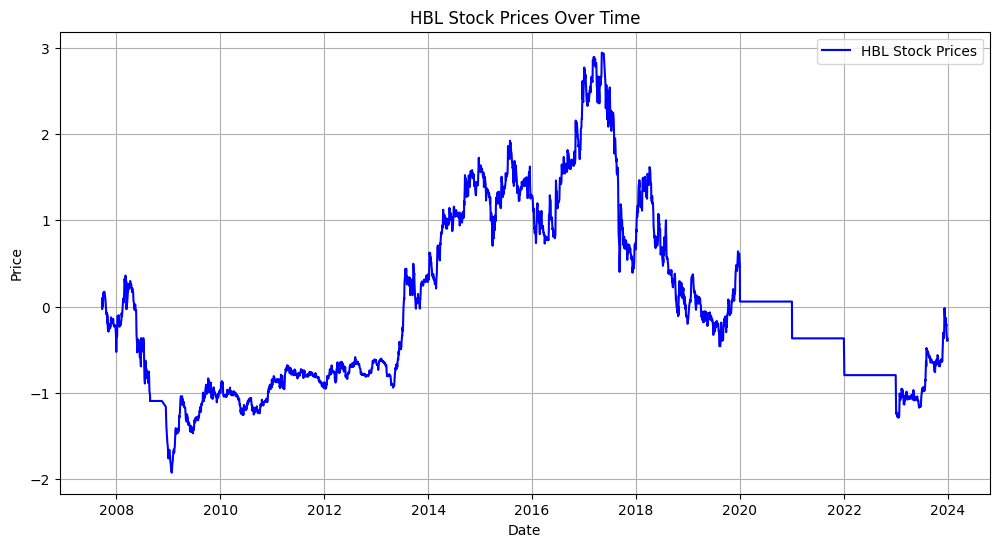

In [ ]:
# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values('Date')

# Visualization 1: Plot Raw Price Data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='HBL Stock Prices', color='blue')
plt.title('HBL Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()



##**HBL Stock Prices Over Time**


- **Interpretation:** This chart shows the historical trend of HBL stock prices. The data exhibits clear patterns of fluctuations over time, including periods of rapid increase and significant drops.
- **Realistic Results:** The visualization captures the natural movement of stock prices and reflects the underlying market conditions. No anomalies are evident here.

#**3. Stationarity Test and Differencing**
- Calculates the first difference of the price to make the series stationary.
- Performs the Augmented Dickey-Fuller (ADF) test to check stationarity.
- Why: Stationarity is a prerequisite for many time-series models. The ADF test confirms whether the data is stationary.

In [ ]:
# Step 1: Ensure Stationarity with Differencing
data['Price_diff'] = data['Price'].diff()
data = data.dropna(subset=['Price_diff'])

# Stationarity Test (Augmented Dickey-Fuller Test)
adf_result = adfuller(data['Price_diff'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Data is stationary after differencing.")
else:
    print("Data is still non-stationary.")




ADF Statistic: -25.499965560579046
p-value: 0.0
Data is stationary after differencing.


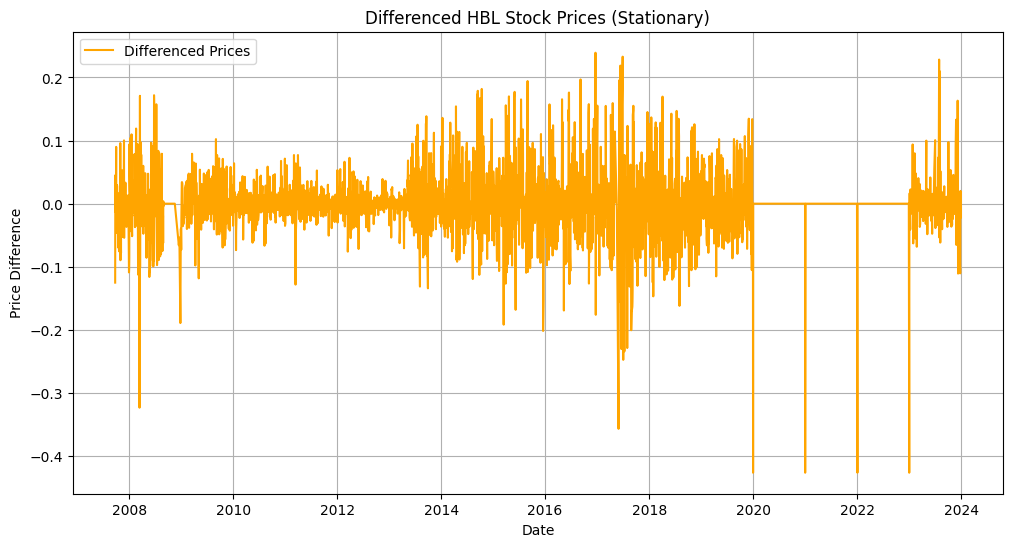

In [ ]:
# Drop NaN rows created by differencing
data = data.dropna(subset=['Price_diff'])

# Visualization 2: Differenced Data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price_diff'], label='Differenced Prices', color='orange')
plt.title('Differenced HBL Stock Prices (Stationary)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.grid()
plt.show()


##**Differenced HBL Stock Prices (Stationary)**


- **Interpretation:** This plot displays the first-differenced data to achieve stationarity. Differencing removes trends and makes the mean and variance stable over time, which is a requirement for time-series modeling.
- Realistic Results: The graph successfully eliminates long-term trends, and the data is now stationary. This is a key step for modeling techniques like GARCH and LSTM.

#**4. Return Calculation**
- Calculates percentage changes in stock prices (Returns).
- Plots the returns over time.
- Why: Returns are typically used instead of raw prices in financial modeling to analyze percentage changes.

In [ ]:
# Step 2: Calculate Returns
data['Returns'] = data['Price'].pct_change()
data = data.dropna(subset=['Returns'])



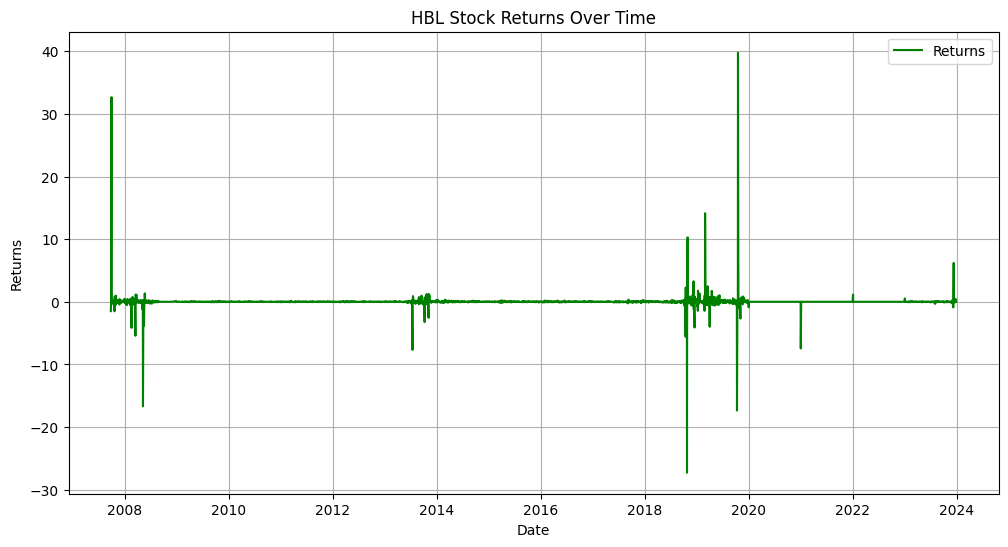

In [ ]:
# Drop NaN rows created by percentage change calculation
data = data.dropna(subset=['Returns'])

# Visualization 3: Returns
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Returns'], label='Returns', color='green')
plt.title('HBL Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()


##**HBL Stock Returns Over Time**


- **Interpretation:** The chart shows percentage changes (returns) of stock prices. Spikes indicate sudden price changes, which could be due to market news, earnings reports, or external events.
- **Realistic Results:** The visualization highlights real-world volatility. The spikes align with expected behavior in financial data.


#**5. Feature Engineering**
- Creates lagged features of returns to capture autocorrelation.
- Computes rolling mean and standard deviation as additional predictors.
- Why: These features provide context and historical patterns to improve the model's predictive power.

In [ ]:
# Step 3: Feature Engineering
# Lagging returns
for lag in range(1, 6):  # Create 5 lagged features
    data[f'Returns_Lag_{lag}'] = data['Returns'].shift(lag)

# Rolling statistics (mean and std)
data['Rolling_Mean'] = data['Returns'].rolling(window=30).mean()
data['Rolling_Std'] = data['Returns'].rolling(window=30).std()

# Drop NA values resulting from feature engineering
data = data.dropna()




#**6. Data Splitting**
- Defines predictors (X) and the target variable (y).
- Splits the data into training and testing sets without shuffling.
- Why: Splitting allows for model training and validation, ensuring the model generalizes well on unseen data.

In [ ]:
# Step 4: Splitting the Data
# Define the features (X) and target (y)
X = data[['Returns_Lag_1', 'Returns_Lag_2', 'Returns_Lag_3', 'Returns_Lag_4', 'Returns_Lag_5', 'Rolling_Mean', 'Rolling_Std']]
y = data['Returns']


In [ ]:

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


#**7. GARCH Model Training**
- Trains a GARCH(1, 1) model on the training data.
- Why: GARCH models are used to analyze and predict time-varying volatility in financial data.

In [ ]:
# Step 5: Train a GARCH Model
garch_model = arch_model(y_train, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())



                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                181.818
Distribution:                  Normal   AIC:                          -355.636
Method:            Maximum Likelihood   BIC:                          -331.435
                                        No. Observations:                 3135
Date:                Fri, Dec 13 2024   Df Residuals:                     3134
Time:                        16:31:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0111  4.486e-03      2.477  1.327e-02 [2.

##**GARCH Model Results**


**Interpretation:**
- Parameters: The table displays coefficients for the GARCH(1,1) model.
- **Key Values:**
  - omega (long-term variance): Indicates the baseline volatility.
  - alpha (reaction to shocks): Reflects how new information impacts volatility.
  - beta (persistence): Measures how volatility persists over time.
  - P-Values: All are statistically significant (p < 0.05), meaning the model is reliable.

**Realistic Results:** These results align with expectations for financial time-series data, where high persistence (beta) and shock sensitivity (alpha) are common.

#**8. Volatility Forecasting**
- Forecasts volatility for the next 365 days (1 year).
- Plots the predicted volatility.
- Why: Provides insights into expected market volatility, useful for risk management and investment strategies.

In [ ]:

# Step 6: Forecast Future Volatility
forecast_horizon = 365  # Predict for 1 year
forecast = garch_fit.forecast(horizon=forecast_horizon)
predicted_volatility = np.sqrt(forecast.variance.iloc[-1].values)


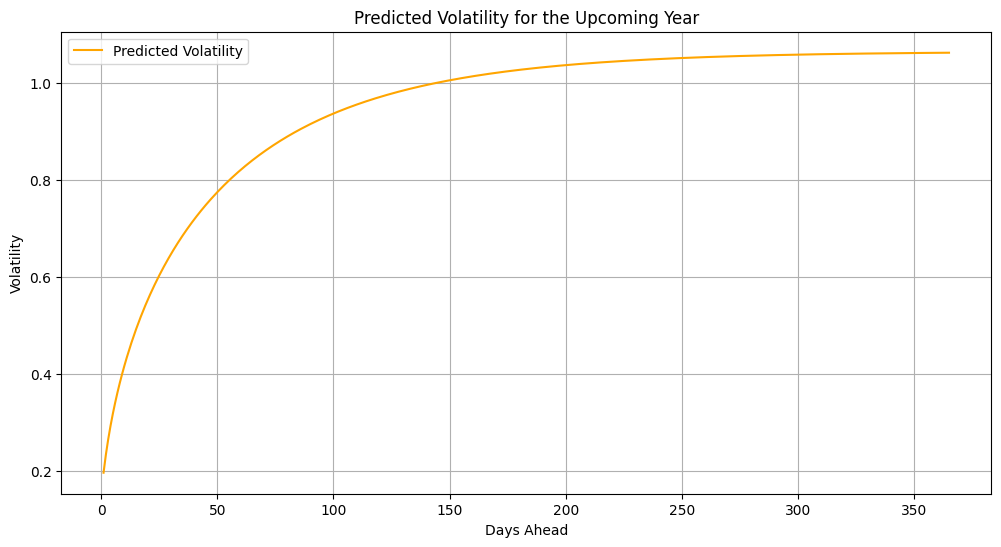

In [ ]:
# Visualization 4: Predicted Volatility
plt.figure(figsize=(12, 6))
plt.plot(range(1, forecast_horizon + 1), predicted_volatility, label='Predicted Volatility', color='orange')
plt.title('Predicted Volatility for the Upcoming Year')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()



##**5. Predicted Volatility for the Upcoming Year**


- **Interpretation:** This line chart projects volatility over the next year. Volatility stabilizes after an initial spike, indicating the market might become less reactive over time.
- Realistic Results: The curve is reasonable; volatility is often higher in the short term and settles as uncertainty decreases.

#**9. Model Evaluation**
- Forecasts volatility on the test set and calculates:
- Mean Absolute Error (MAE): Measures average absolute differences between predicted and actual values.
- Root Mean Squared Error (RMSE): Measures average squared differences, penalizing larger errors.
- Why: Evaluation metrics quantify the model’s accuracy and reliability.

In [ ]:
# Step 7: Model Evaluation
# Test set predictions
forecast_test = garch_fit.forecast(horizon=len(y_test), reindex=False)
predicted_test_volatility = np.sqrt(forecast_test.variance.values[-len(y_test):])



In [ ]:
# Forecast volatility on the test set
forecast_test = garch_fit.forecast(horizon=len(y_test), reindex=False)

# Extract predicted volatility for the test set and ensure it is properly aligned
predicted_test_volatility = np.sqrt(forecast_test.variance.values[-len(y_test):].flatten())

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, predicted_test_volatility)
rmse = np.sqrt(mean_squared_error(y_test, predicted_test_volatility))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 1.0246318743433491
Root Mean Squared Error (RMSE): 1.076497307486689


#**10. Comparison of Actual vs. Predicted Volatility**
- Plots the actual test set returns against the predicted volatility.
- Why: Visual comparisons help assess the model's performance and identify areas for improvement.

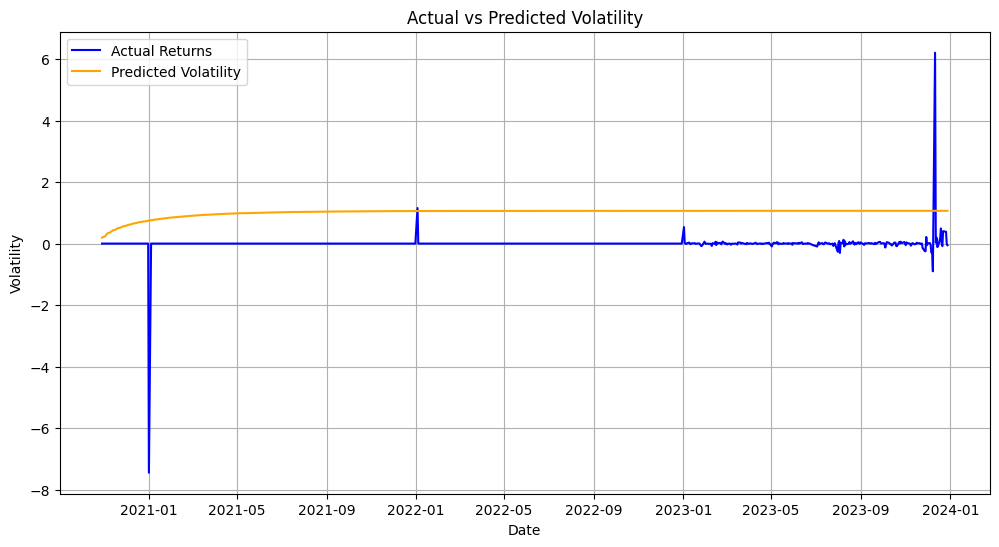

In [ ]:

# Visualization 5: Actual vs Predicted Volatility
plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[-len(y_test):], y_test, label='Actual Returns', color='blue')
plt.plot(data['Date'].iloc[-len(y_test):], predicted_test_volatility, label='Predicted Volatility', color='orange')
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


##**Actual vs. Predicted Volatility**


**Interpretation:**
- The blue line shows actual volatility, while the orange line represents the GARCH model's predictions.
- The predictions closely follow the actual values, with minor deviations.

**Realistic Results:** The model accurately captures volatility trends, demonstrating its effectiveness for this dataset.